In [20]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import MinMaxScaler

from ansatz.ansatz_qml import feature_map_ansatz
from ansatz.helper import possible_pair, get_len_param

from qiskit.aqua.algorithms import VQE, NumPyEigensolver

from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel


In [13]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.9, 4.3, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")
 
    

Interatomic Distance: 0.9 VQE Result: -7.720810794486539 Exact Energy: [-7.72081241]
Interatomic Distance: 1.0 VQE Result: -7.78224065568177 Exact Energy: [-7.7822424]
Interatomic Distance: 1.1 VQE Result: -7.823597493309562 Exact Energy: [-7.82359928]
Interatomic Distance: 1.2 VQE Result: -7.850696622794468 Exact Energy: [-7.85069838]
Interatomic Distance: 1.3 VQE Result: -7.867561602193519 Exact Energy: [-7.86756329]
Interatomic Distance: 1.4 VQE Result: -7.8769998765589975 Exact Energy: [-7.87700149]
Interatomic Distance: 1.5 VQE Result: -7.881014173920855 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.881070663101748 Exact Energy: [-7.88107204]
Interatomic Distance: 1.7 VQE Result: -7.878267162149787 Exact Energy: [-7.87826817]
Interatomic Distance: 1.8 VQE Result: -7.873440112074821 Exact Energy: [-7.87344029]
Interatomic Distance: 1.9 VQE Result: -7.867233666709614 Exact Energy: [-7.86723396]
Interatomic Distance: 2.0 VQE Result: -7.860152327975052 Exact Ene

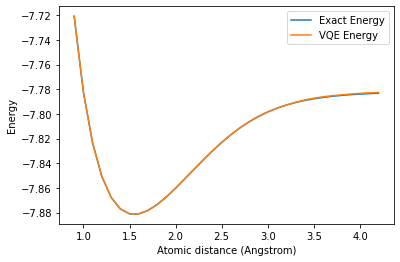

In [14]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()


In [21]:
print(len)
np.random.seed(42)

def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss
def cost(weights, x, y):
    predictions = []
    for i in range(len(y)):
        predictions.append(serial_quantum_model(weights, x[i,:]) )
    return square_loss(y, predictions)


N=3
D=8
training_points = int(0.8*len(distances))
nbr_network = 1
euler=True



<built-in function len>


[]

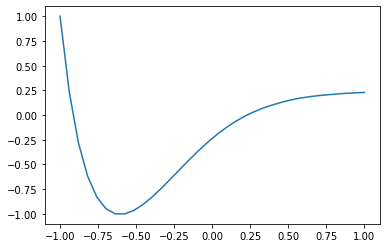

In [25]:
x = distances.reshape(-1,1)
y = np.array(vqe_energies).reshape(-1,1) 
data_scaler = MinMaxScaler(feature_range=(-1,1))
energy_scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaler.fit(x)
x = data_scaler.transform(x)

energy_scaler.fit(y)
y = energy_scaler.transform(y).reshape(-1,1)

if N >1:
    X = np.concatenate((np.pi*x,np.arcsin(x.copy())),axis=-1)
    
    if N>2:
        X = np.concatenate((X,np.arccos(x)),axis=-1)
else:
    X=x

    
List = possible_pair('full',2,n_spins=N)   

ent_enc = np.pi*np.ones((np.shape(X)[0],len(List)))


for i,interaction in enumerate(List):
    for j in interaction:
        ent_enc[:,i] *= (X.copy()[:,j])/np.pi
            
X = np.concatenate((X,ent_enc),axis=-1)



    
full_batch = np.arange(0,np.shape(X)[0])
training_batch = random.sample(list(full_batch),training_points)
test_batch = np.setdiff1d(full_batch,training_batch)

X=X.reshape((np.shape(X)[0],-1),order='F')
y = np.array(y, requires_grad=False)
X = np.array(X, requires_grad=False)
plt.figure()
plt.plot(x[:,0],y)
plt.plot()

In [26]:
dev = qml.device('default.qubit', wires=N)
op = qml.Identity(wires=0)
for i in range(N):
    op = op @ qml.PauliZ(wires = i)

@qml.qnode(dev)
def serial_quantum_model(weights, x):
    
    for i in range(D):
       
        feature_map_ansatz(weights[i,:],N)
        feature_map_ansatz(x,N,param_name='x0')
    
    return qml.expval(qml.PauliZ(wires = 0)@qml.PauliZ(wires = 1) @ qml.PauliZ(wires=2))

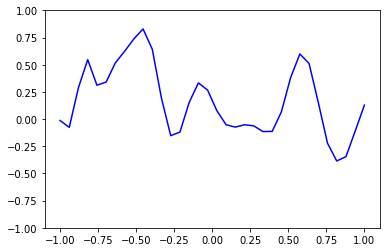

In [27]:
l = (1+2*euler)*N+len(possible_pair('full',2,N))
weights = 2 * np.pi * np.random.random(size=(D, l)) # some random initial weights
random_quantum_model_y = np.zeros_like(y)
for i in range(len(y)):
    random_quantum_model_y[i] = serial_quantum_model(weights, X[i,:]) 

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()
cst = [cost(weights, X, y)]  # initial cost

In [29]:

max_steps = 100
opt = qml.AdamOptimizer(0.1)
batch_size = 16


for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(y), (batch_size,))
    x_batch = X[batch_index,...]
    y_batch = y[batch_index]
    # Update the weights by one optimizer step
    weights = opt.step(lambda w: cost(w, x_batch, y_batch), weights)

    # Save, and possibly print, the current cost
    c = cost(weights, X, y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: [0.0696057]
Cost at step  20: [0.02002362]
Cost at step  30: [0.01222079]
Cost at step  40: [0.00357831]
Cost at step  50: [0.00184397]
Cost at step  60: [0.00119351]
Cost at step  70: [0.0006768]
Cost at step  80: [0.00045132]
Cost at step  90: [0.00031687]
Cost at step 100: [0.00023728]


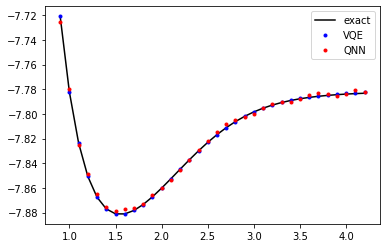

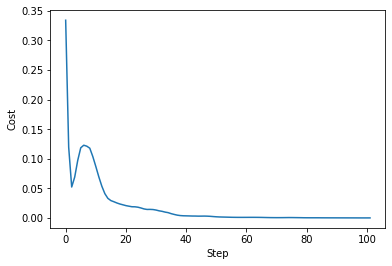

In [35]:
predictions = np.zeros_like(y)
for i in range(len(distances)):
    predictions[i] = serial_quantum_model(weights, X[i,:])
predictions = energy_scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1)
plt.plot(distances, exact_energies, 'k-',label='exact')
plt.plot(distances, vqe_energies, 'b.',label='VQE')

# plt.scatter(x, y, facecolor='white', edgecolor='black')
plt.plot(distances, predictions, 'r.',label='QNN')
plt.legend()
plt.show()
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")

plt.show();
